In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Positional Encoding

In [2]:
class PositionalEncoding(tf.keras.layers.Layer) :
    def __init__(self, position, d_model) :
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model) :
        angles = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        
        return position * angles
    
    def positional_encoding(self, position, d_model) :
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        print(pos_encoding.shape)
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs) :
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


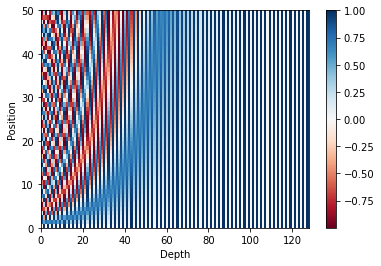

In [3]:
sample_pos_encoding = PositionalEncoding(50,128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled dot product attention

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # size of query : (batch_size, num_head, length of query, d_model/num_heads)
    # size of key : (batch_size, num_head, key of query, d_model/num_heads)
    # size of value : (batch_size, num_head, length of value, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, length of key's sentence)
    
    # Q*K = Matrix of Attention score
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # Scaling
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # Masking
    if mask is not None:
        logits += (mask * -1e9)
        
    # Attention weight : (batch_size, num_heads, length of query's sentence, length of key's sentence
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # Output : (batch_size, num_heads, length of query's sentence, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

#### Test Scaled dot product attention fuction

In [5]:
#Test scaled_dot_product_attention fuction
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                     [0,10,0],
                     [0,0,10],
                     [0,0,10]], dtype=tf.float32) #(4, 3)
temp_v = tf.constant([[   1,0],
                     [  10,0],
                     [ 100,5],
                     [1000,6]], dtype=tf.float32) #(4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) #(1, 3)

In [6]:
temp_out, temp_att_wgt = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_att_wgt)
print(temp_out)

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [7]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_att_wgt = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_att_wgt)
print(temp_out)

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [8]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)
temp_out, temp_att_wgt = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_att_wgt)
print(temp_out)

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


#### Padding mask function

In [9]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0), tf.float32)
    # (batch_size, 1, 1, length of key's sentence)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [10]:
print(create_padding_mask(tf.constant([[1,44,777,0,29]])))

tf.Tensor([[[[0. 0. 0. 1. 0.]]]], shape=(1, 1, 1, 5), dtype=float32)


## Multi-head Attention

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        #define dense layers
        self.query_dense = tf.keras.layers.Dense(units=d_model) #W_Q
        self.key_dense = tf.keras.layers.Dense(units=d_model) #W_K
        self.value_dense = tf.keras.layers.Dense(units=d_model) #W_V
        self.dense = tf.keras.layers.Dense(units=d_model) #W_O
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
            
        return tf.transpose(inputs, perm=[0,2,1,3])
        
    def call(self, inputs):
        query, key, value, mask = inputs["query"], inputs["key"], inputs["value"], inputs["mask"]
        batch_size = tf.shape(query)[0]
        
        # W_Q, W_K, W_V Dense layers
        # (batch_size, length fo (q,k,v)'s sentence, depth = d_model/num_heads)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        #Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot product attention
        # (batch_size, num_heads, length of query's sentence, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, length of query's sentence, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # Concatenate
        # (batch_size, length of query's sentence, num_heads, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # W_O Dense layers
        # (batch_size, length of query's sentence, num_heads, d_model)
        outputs = self.dense(concat_attention)
        
        return outputs

## Assemble Encoder

In [12]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    #Padding Mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    #Multi-head attention
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask})
    
    #Dropout
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    #Layer Normalization & Residual Connection
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    #Position-wise FFNN
    outputs = tf.keras.layers.Dense(units=dff, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    #Dropout
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    #Layer Normalization & Residual Connection
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Stack the Encoder

In [13]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    #Padding Mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    #Positional Encoding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    #Stack the Encoder n peices
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i))([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Look-ahead Mask

In [14]:
def create_look_ahead_mask(x):
    #Look-ahead Mask
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones(shape=(seq_len, seq_len)), -1, 0)
    #Padding Mask
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [15]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 777]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## Assemble Decoder

In [16]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encder_outputs")
    
    #Look-ahead Mask
    look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
    
    #Padding Mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    #1st Multi-head Attention
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={"query": inputs, "key": inputs, "value": inputs, "mask": look_ahead_mask}) #Q == K == V
    
    #Layer Normalization & Residual Connection
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    #2nd Multi-head Attention
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={"query": attention1, "key": enc_outputs, "value": enc_outputs, "mask": padding_mask}) #Q != K == V
    
    #Dropout
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    #Layer Normalization & Residual Connection
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    #Position-wide FFNN
    outputs = tf.keras.layers.Dense(units=dff, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    #Dropout
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

## Stack the decoder

In [17]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    #Look-ahead mask & Padding mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    #Embedding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    #Positional Encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    #Dropout
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    #Stack the decoder n peices
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name="decoder_layer_{}".format(i))(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
        return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

# Build Transformer (Combine Encoder and Decoder)

In [18]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    #Input for Encoder
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    #Input for Decoder
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    #Encoder's Padding mask
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask")(inputs)
    
    #Decoder's Look-ahead mask
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask")(dec_inputs)
    
    #Decoder's Padding mask
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask")(inputs)
    
    #Encoder's output
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    #Decoder's output
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    #Output layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Hyperparameter tuning

In [19]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(small_transformer, to_file="Models/small_transformer.png", show_shapes=True)

(1, 9000, 128)
(1, 9000, 128)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Define loss function

In [20]:
def loss_fuction(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

## Learning rate